In [177]:
import bs4; print( 'bs4 ' + bs4.__version__)
from bs4 import BeautifulSoup, SoupStrainer

import sklearn; print( 'sklearn ' + sklearn.__version__)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

import nltk; print( 'nltk ' + nltk.__version__)
from nltk import word_tokenize, pos_tag, RegexpParser;
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, LancasterStemmer

# from autocorrect import spell; print('autocorrect 0.3.0')

import re; print('re ' + re.__version__)
import requests; print('requests ' + requests.__version__)

import pandas as pd; print('pandas ' + pd.__version__)
import seaborn as sns; print('seaborn ' + sns.__version__)

import pyLDAvis; print('pyLDAvis', pyLDAvis.__version__)
import pyLDAvis.sklearn


bs4 4.6.3
sklearn 0.19.1
nltk 3.3
re 2.2.1
requests 2.19.1
pandas 0.22.0
seaborn 0.8.1
pyLDAvis 2.1.2


# Final Project - Topic Modeling

First we continue where we left off with [Homework 5](https://github.com/kjprice/smu-nlp/blob/e769b93945e6f45ae90aab3ec53b6595ae7bc7da/homework/Homework%205.ipynb).

### Code from Homework 5


In [2]:
# The home page for various movies' reviews, from which will get the links for individual reviews
review_home_urls = {
    'green_mile': 'https://www.imdb.com/title/tt0120689/reviews?ref_=tt_ql_3',
    'forest_gump': 'https://www.imdb.com/title/tt0109830/reviews?ref_=tt_ov_rt',
    'cast_away': 'https://www.imdb.com/title/tt0162222/reviews?ref_=tt_ov_rt',
    'terminal': 'https://www.imdb.com/title/tt0362227/reviews?ref_=tt_ql_3',
    'catch_me_if_you_can': 'https://www.imdb.com/title/tt0264464/reviews?ref_=tt_ql_3',
    'road_to_perdition': 'https://www.imdb.com/title/tt0257044/reviews?ref_=tt_ql_3',
}
def get_text_from_url(url):
    return requests.get(url).text
text = get_text_from_url(review_home_urls['green_mile'])


In [3]:
def get_all_links_from_html(html):
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer('a', href=True))
    urls = [str(tag.attrs['href']) for tag in tags]
    return urls
all_links = get_all_links_from_html(text)

In [4]:
def get_review_urls_from_links(links):
    url_template = 'https://www.imdb.com{}'
    # url_template = 'http://www.gutenberg.org/files/{}/{}-h/{}-h.htm'
    return [url_template.format(link) for link in links]

urls = get_review_urls_from_links(all_links)

In [5]:
def relevent_link(link):
    if '/review/' in link:
        return True
    return False

In [6]:
def get_relevent_links(links):
    relevent_links = filter(relevent_link, all_links)
    unique_relevent_links = set(relevent_links)
    return list(unique_relevent_links)
relevent_urls = get_relevent_links(urls)
len(relevent_urls)

25

In [7]:
def strain_content(name, attrs):
    if name == 'div' and dict(attrs).get('class', None) == 'content':
        return True
    return False
def clean_review_text(text):
    return re.split('\\n\\n\s+\d+ out of \d+', text)[0]
def get_review_from_url(url):
    html = get_text_from_url(url)
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer(strain_content))
    review = clean_review_text(tags.text)
    return review

In [8]:
def get_review_from_site(url):
    reviews = []

    reviews_home_text = get_text_from_url(url)
    all_links = get_all_links_from_html(reviews_home_text)
    relevent_links = get_relevent_links(all_links)

    
    
    
    review_urls = get_review_urls_from_links(relevent_links)
    for url in review_urls:
        reviews.append(get_review_from_url(url))
        # break
    return reviews

In [9]:
def get_reviews_from_all_sites():
    all_reviews = []
    review_titles = review_home_urls.keys()
    for title in review_titles:
        review_home_url = review_home_urls[title]
        all_reviews = all_reviews + get_review_from_site(review_home_url)
    return all_reviews

## Retrieve All Reviews

In [10]:
all_reviews = get_reviews_from_all_sites()

In [11]:
len(all_reviews)

150

In [12]:
all_reviews[0][0:100]

'\nNow a resident in a rest home, one time head warden on death row, Paul Edgecomb, is struggling with'

## Preprocess Data

In [13]:
def sentences_to_words(sentences):
    return [word_tokenize(sentence) for sentence in sentences]
# sentences_to_words([all_reviews[0]])[0][0:5]

In [14]:
custom_stop_words = ['the', 'green', 'mile', 'shawshank', 'redemption', 'one']
stop_words = custom_stop_words + stopwords.words('english')
def remove_stop_words(words):
    return [word for word in words if word not in stop_words]
remove_stop_words(['he', 'her', 'boss', '.', 'the'])

['boss', '.']

In [15]:
def include_only_numbers_and_letters(words):
    regex_matcher = '^[a-zA-Z0-9]+$'
    return [word for word in words if re.match(regex_matcher, word)]
# include_only_numbers_and_letters(['1', 'KJ', '.'])

In [16]:
#stemmer = PorterStemmer()
#stemmer = SnowballStemmer('english')
stemmer = LancasterStemmer()
def lemmatize_words(words):
    return [stemmer.stem(word) for word in words]
# lemmatize_words(['running', 'fastest', 'hats'])

In [92]:
def preprocess_documents(documents):
    documents_with_formatted_words = [document.lower().strip() for document in documents]
    documents_of_words = sentences_to_words(documents_with_formatted_words)
    content_words_and_characters = [remove_stop_words(words) for words in documents_of_words]
    content_words = [include_only_numbers_and_letters(characters) for characters in content_words_and_characters]
    lematized_words = [lemmatize_words(words) for words in content_words]
    return lematized_words  
preprocess_documents(all_reviews[0:2])[0][0:5]

['resid', 'rest', 'hom', 'tim', 'head']

In [93]:
documents_of_words = preprocess_documents(all_reviews)
documents_of_words[0][0:7]

['resid', 'rest', 'hom', 'tim', 'head', 'ward', 'dea']

### Take a look at words

In [94]:
list_of_all_words = [word for document in documents_of_words for word in document]
len(list_of_all_words)

17454

In [95]:
# Unique Words
len(set(list_of_all_words))

1030

### Flatten documents back to sentences

In [96]:
flattened_documents = [' '.join(document) for document in documents_of_words]

## Perform Topic Modeling

Inspired, in part by https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

In [154]:
# Settings
NUMBER_OF_FEATURES = 1000
NUMBER_OF_TOPICS  = 10
NUMBER_OF_TOP_WORDS = 10

In [155]:
def topics_to_map(model, feature_names, no_top_words):
    map = []
    for topic_idx, topic in enumerate(model.components_):
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        map.append(stuff)
    return map


In [156]:
# Helper function 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}:".format(topic_idx))
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print (stuff)

### Vectorize (Bag Of Words)

In [157]:
tf_vectorizer = CountVectorizer(max_features=NUMBER_OF_FEATURES)
tf = tf_vectorizer.fit_transform(flattened_documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [158]:
flattened_documents[0][0:100]

'resid rest hom tim head ward dea row paul edgecomb struggling untold mem film bring back recount sto'

### NMF

In [159]:
nmf = NMF(n_components=NUMBER_OF_TOPICS, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tf)

In [160]:
nmf_topic_map = topics_to_map(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)
display_topics(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)

Topic 0:
com film best lik dunt block tal hank get king
Topic 1:
movy watch seen ev lik tim ca think feel forget
Topic 2:
film year paul movy michael dea man pow think prison
Topic 3:
film long tim many howev feel story slow emot work
Topic 4:
dunt rol hank film tom edgecomb remind good percy paul
Topic 5:
prison men story innoc man edgecomb guard king stev movy
Topic 6:
movy book gre would read see perform peopl king michael
Topic 7:
movy cast yet ev perform guard michael find dep charact
Topic 8:
story book screen film lik king leng bring nev three
Topic 9:
mak film paul john hum emot real darabont dunt bril


### LDA

In [161]:
lda = LatentDirichletAllocation(n_topics=NUMBER_OF_TOPICS, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)



/usr/local/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [162]:
display_topics(lda, tf_feature_names, NUMBER_OF_TOP_WORDS)


Topic 0:
movy cast ev yet perform guard story hour three direct
Topic 1:
film bring cast dunt tru john pow play act emot
Topic 2:
movy book story king darabont read would gre emot see
Topic 3:
movy story hum bril lik writ oth song see tak
Topic 4:
movy film would best com lik block dunt get mak
Topic 5:
movy think nev titl view steph hour hank tim tom
Topic 6:
scen film bring movy perform hank three mad del screenwriter
Topic 7:
film mak dunt prison paul tim hank real good emot
Topic 8:
rich ful eith watch charact certain right journey film lik
Topic 9:
movy seen ev film michael hank year lik story prison


In [163]:
topic_map = nmf.transform(tf)

# Visualizations

With help from https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

In [164]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

In [165]:
tsne_lda = tsne_model.fit_transform(topic_map)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.397199
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.971416
[t-SNE] Error after 1000 iterations: -3.672542


In [166]:
categories = review_home_urls.keys()

In [167]:
categories_vector = []
for category in categories:
    for i in range(int(len(all_reviews) / len(categories))):
        categories_vector.append(category)

In [169]:
x = pd.DataFrame({
    'x': tsne_lda[:, 0],
    'y': tsne_lda[:, 1],
    'group': categories_vector,
    text: all_reviews
})

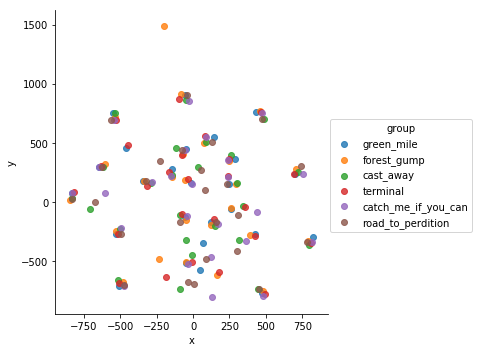

In [170]:
sns.lmplot(x='x', y='y', fit_reg=False, data=x, hue='group', x_jitter=40, y_jitter=40)

### pyLDAvis

In [176]:
# Help by https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(nmf, tf, tf_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      15.474589        1       1 -123.049324  407.018280
2      14.709126        1       2 -237.709015   51.556286
0      11.535850        1       3 -228.992020 -505.472717
4      10.716056        1       4 -482.594513 -202.607193
9      10.411071        1       5  -49.444897 -217.875305
3       9.629104        1       6   89.866127   80.295982
7       8.342430        1       7  214.350937 -433.260468
8       7.406068        1       8 -513.208008  239.079803
5       6.180483        1       9  286.660583  351.496521
6       5.595222        1      10  393.510345  -86.079643, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
569   Default  417.000000      movy  417.000000  30.0000  30.0000
100   Default   89.000000      book   89.000000  29.0000  29.0000
390   Default   64.000000       gre   64.000000  28.0000  28.0000
993   Default   99.000000     would   99.000000  27.0000  27.0000
846   Default  173.000000     story  173.000000  26.0000  26.0000
701   Default   49.000000      read   49.000000  25.0000  25.0000
763   Default   89.000000       see   89.000000  24.0000  24.0000
962   Default   63.000000     watch   63.000000  23.0000  23.0000
673   Default  141.000000    prison  141.000000  22.0000  22.0000
128   Default  102.000000      cast  102.000000  21.0000  21.0000
999   Default   41.000000       yet   41.000000  20.0000  20.0000
398   Default   82.000000     guard   82.000000  19.0000  19.0000
276   Default  112.000000      emot  112.000000  18.0000  18.0000
329   Default   87.000000      feel   87.000000  17.0000  17.0000
551   Default   49.000000       men   49.000000  16.0000  16.0000
543   Default  104.000000       mak  104.000000  15.0000  15.0000
766   Default   85.000000      seen   85.000000  14.0000  14.0000
757   Default   49.000000    screen   49.000000  13.0000  13.0000
334   Default  232.000000      film  232.000000  12.0000  12.0000
156   Default   74.000000       com   74.000000  11.0000  11.0000
891   Default   51.000000     three   51.000000  10.0000  10.0000
502   Default  107.000000      king  107.000000   9.0000   9.0000
289   Default  138.000000        ev  138.000000   8.0000   8.0000
436   Default   73.000000      hour   73.000000   7.0000   7.0000
198   Default   68.000000  darabont   68.000000   6.0000   6.0000
659   Default   36.000000     point   36.000000   5.0000   5.0000
640   Default  115.000000   perform  115.000000   4.0000   4.0000
998   Default   62.000000      year   62.000000   3.0000   3.0000
896   Default  117.000000       tim  117.000000   2.0000   2.0000
265   Default   88.000000  edgecomb   88.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
452   Topic10    8.336464    imagin   17.674992   2.1317  -4.7510
659   Topic10   16.485468     point   36.514710   2.0880  -4.0691
531   Topic10    8.122167      look   18.719607   2.0483  -4.7770
434   Topic10   16.872187       hop   38.890010   2.0482  -4.0459
656   Topic10    8.223198      plot   21.208032   1.9358  -4.7647
576   Topic10    8.228685       nam   21.223643   1.9358  -4.7640
708   Topic10    8.228685    receiv   21.223643   1.9358  -4.7640
748   Topic10    7.987928      said   21.231199   1.9057  -4.7937
993   Topic10   36.440146     would   99.252882   1.8813  -3.2759
589   Topic10   16.228243     novel   44.035497   1.8850  -4.0849
763   Topic10   27.987189       see   89.987597   1.7153  -3.5399
654   Topic10   16.785638      play   51.815561   1.7561  -4.0511
569   Topic10   70.751666      movy  417.917433   1.1071  -2.6124
502   Topic10   17.038588      king  107.141867   1.0446  -4.0361
640   Topic10   17.232375   perform  115.191600   0.9835  -4.0248
554   Topic10   16.889716   michael  123.889519   0.8906  -4.0449
234   Topic10    9.400902  

### Testing stuff

In [135]:
import numpy as np

In [142]:
primary_topics = [np.argmax(transformed_topics) for transformed_topics in lda.transform(tf)]

In [152]:
primary_topics_text = [nmf_topic_map[topic_index] for topic_index in primary_topics]

In [124]:
a = tf[0]

In [126]:
tf_vectorizer.inverse_transform(a)

[array(['30', 'act', 'also', 'alway', 'annoy', 'around', 'attract', 'auth',
        'back', 'bad', 'bet', 'bit', 'black', 'bring', 'build', 'ca',
        'cal', 'cam', 'cast', 'chair', 'childr', 'coffey', 'com', 'comp',
        'complet', 'compr', 'cor', 'could', 'cruel', 'cur', 'dea', 'decay',
        'despit', 'detry', 'diff', 'difficult', 'direct', 'drop', 'dunt',
        'easy', 'edgecomb', 'el', 'emot', 'er', 'every', 'fac', 'fail',
        'feel', 'film', 'find', 'flaw', 'found', 'gentl', 'get', 'gift',
        'giv', 'good', 'guil', 'hank', 'head', 'help', 'hom', 'howev',
        'hug', 'hum', 'includ', 'involv', 'john', 'known', 'leng', 'lik',
        'littl', 'liv', 'long', 'los', 'lost', 'lov', 'main', 'mak', 'man',
        'many', 'ment', 'minut', 'mom', 'mors', 'mous', 'mov', 'movy',
        'much', 'murd', 'mystery', 'occas', 'oft', 'overlong', 'overtim',
        'paul', 'peac', 'perform', 'play', 'pow', 'prison', 'put', 'quit',
        'rap', 'real', 'rec', 'recount', 're